 
**Reconstruction LSTM AutoEncoder**

*   가장 간단한 LSTM 오토인코더는 각 인풋 Sequence를 학습해서 reconstruct함 
*   9개의 간단한 수열로 연습 



In [1]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.layers import Input
from keras.models import Model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Using TensorFlow backend.


In [2]:
# define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(sequence)
sequence = sequence.reshape((1, n_in, 1))

인코더-디코더 LSTM 구조를 정의해야함. 
9개의 타임스텝을 인풋시퀀스로 받고 (피쳐는1개) 아웃풋으로 9개의 타임스텝으로 냄 (피쳐는1개) 

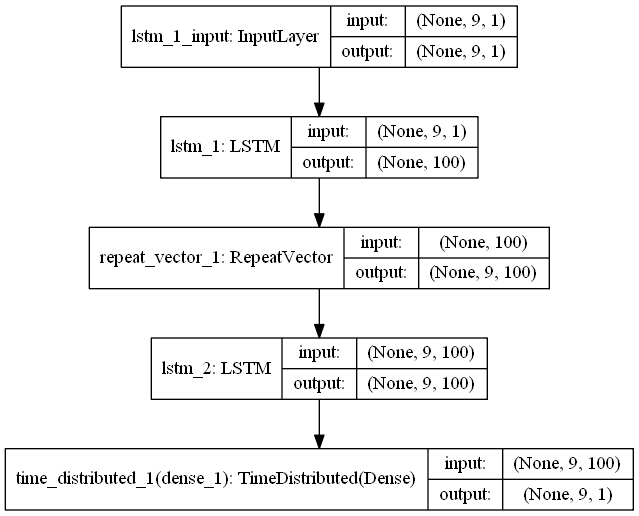

In [3]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

In [4]:
# demonstrate recreation
yhat = model.predict(sequence, verbose=0)
print(yhat[0,:,0])

[0.10412016 0.20055893 0.29924992 0.3991325  0.49947697 0.59985924
 0.70011955 0.800318   0.9000913 ]


***Prediction LSTM AutoEncoder***

*   위의 모델을 수정해서 재생성이 아닌 예측모델을 만듬 
*   아웃풋은 [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 와 근점해야함 
*   모델은 인풋 시퀀스가 9개이고 아웃풋 시퀀스는 8개 



In [5]:
# define input sequence
seq_in = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(seq_in)
seq_in = seq_in.reshape((1, n_in, 1))
# prepare output sequence
seq_out = seq_in[:, 1:, :]
n_out = n_in - 1

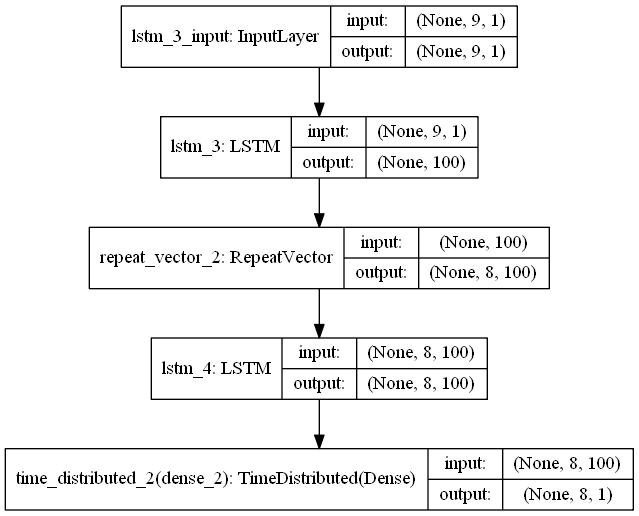

In [6]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='predict_lstm_autoencoder.png')


In [7]:
# fit model
model.fit(seq_in, seq_out, epochs=300, verbose=0)
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)
print(yhat[0,:,0])

[0.1637956  0.28845912 0.40321535 0.5100084  0.61104584 0.707384
 0.79992735 0.8894657 ]


***Composite LSTM AutoEncoder***

*   Composite모형에서는 1개의 인코더와 2개의 디코로 이루어져 있고 각각 Reconstruction그리고 예측에 쓰임 


In [8]:
# 인코더정의
visible = Input(shape=(n_in,1))
encoder = LSTM(100, activation='relu')(visible)

In [9]:
#재생성 디코더 정의 
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(100, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(1))(decoder1)

In [10]:
# 예측 디코더 정의
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(100, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(1))(decoder2)

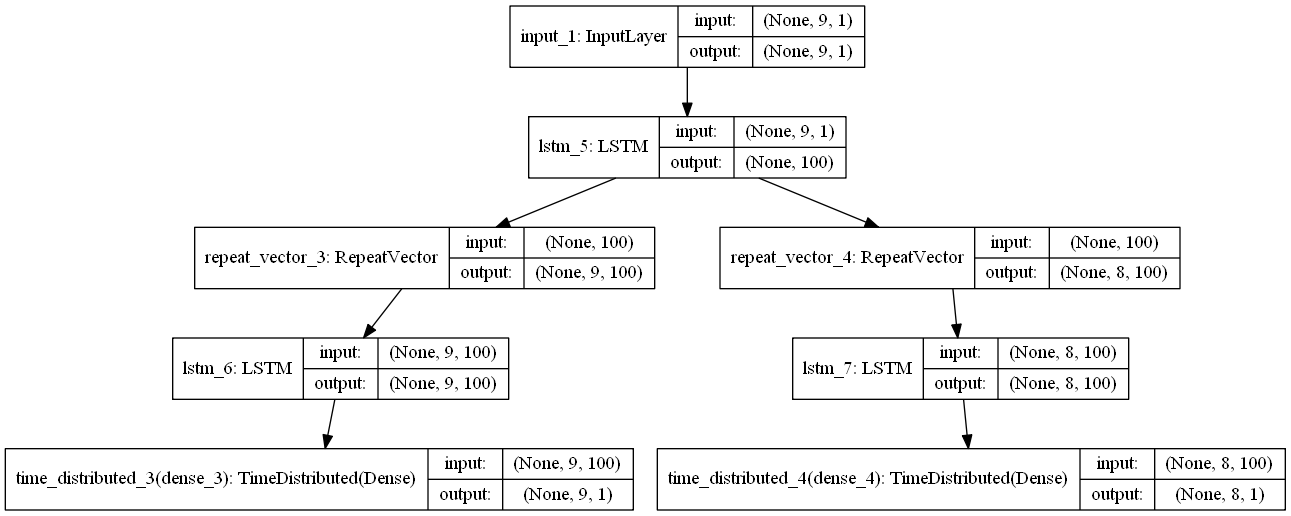

In [11]:
# 최종 모델 정의
model = Model(inputs=visible, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

In [12]:
# fit model
model.fit(seq_in, [seq_in,seq_out], epochs=300, verbose=0)
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)
print(yhat)

[array([[[0.10886166],
        [0.20686188],
        [0.30365303],
        [0.40010428],
        [0.4970158 ],
        [0.5951737 ],
        [0.69539243],
        [0.7985542 ],
        [0.9056472 ]]], dtype=float32), array([[[0.19687147],
        [0.30371717],
        [0.39799714],
        [0.49863276],
        [0.6003493 ],
        [0.70122653],
        [0.8007541 ],
        [0.8991533 ]]], dtype=float32)]


***StandAlone LSTM AutoEncoder***

*   모델종류와 상관없이 인코더가 학습된 후에는 디코더를 제거하고 인코딩모델만 Keep할 수 있음 
*   인코더는 input seqeence 를 길이가 fix된 encoded vector 로 쓸 수 있음 


In [13]:
# define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(sequence)
sequence = sequence.reshape((1, n_in, 1))

In [14]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)

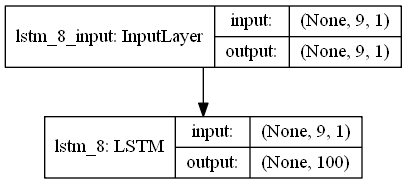

In [15]:
# connect the encoder LSTM as the output layer
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
plot_model(model, show_shapes=True, to_file='lstm_encoder.png')

In [16]:
# get the feature vector for the input sequence
yhat = model.predict(sequence)
print(yhat.shape)
print(yhat)

(1, 100)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.34364018e-02 5.68047762e-02 0.00000000e+00 0.00000000e+00
  8.93031359e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.48474777e-02 0.00000000e+00 6.85440525e-02 0.00000000e+00
  3.78920548e-02 0.00000000e+00 7.45210564e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.32530590e-02 1.99929946e-05
  0.00000000e+00 7.00528473e-02 0.00000000e+00 0.00000000e+00
  9.39610079e-02 0.00000000e+00 6.69750944e-02 6.67898878e-02
  1.06925614e-01 0.00000000e+00 3.81430872e-02 3.94005775e-02
  6.85217530e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.17599662e-02 6.97328746e-02 1.06095821e-01 5.47593348e-02
  7.72827044e-02 6.90102875e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 8.69059712e-02 5.75269461e-02 1.04240729e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 6.64102212e-02
  9.40968245e-02 0.00000000e+00 0.00000000e+00 7.35494271e-02

인코더 모델만을 저장해서 나중에 쓸수 있음 